In [1]:
# ╔═╡ 70122f72-ce57-11ed-34a3-edae52aeeea1
begin
	using Random
	using LinearAlgebra
	using Statistics: mean
end

# ╔═╡ 15481c8b-7a2a-46ae-bc99-86887b504106
begin
	using Plots
	using Flux
	using STFT
end

# ╔═╡ 9c2ef567-0e18-4b5a-ab99-b51c32cde693
using Flux: train!, mse

In [2]:
# ╔═╡ 03130321-be9c-4aaf-9b22-505d072fc565
begin
	# Generate notes for fake data set
	sample_rate = 44000. / 16. # 16th reduction from typical sample rate
	t = range(0, 1.5, step=1/sample_rate)
	f = 100; #Hz
end

# ╔═╡ 9a29e245-3124-4beb-abd6-085810af4c4f
begin
	# amplitude normalization slightly under 1 to avoid speaker clipping issues
	ceiling = 0.98
	normalized(y) =  y ./ maximum(abs.(y)) .* ceiling
end

# ╔═╡ 6fc6eb2a-44f8-4051-b95f-cb526dcc7404
function delay_note(y, t, delay)
    index = findfirst(t .>= delay)
    z = copy(y)
    z[index:end] = y[1:end-index+1]
    z[1:index-1] .= 0
    return z
end

# ╔═╡ 06d52688-756b-43ee-b73f-81a5d5426d56
function make_note(t, f₀; N=10, delay=0, ϕ=0)
    y = sum(exp.(-n*t).*sin.(2π*f₀*t*n .+ ϕ)/n for n ∈ 1:N) #N is number of harmonics
    if delay != 0
        y = delay_note(y, t, delay)
    end
    return normalized(y)
end

function make_held_note(t, f₀; N=10, ϕ=0)
    y = sum(sin.(2π*f₀*t*n .+ ϕ)/n for n ∈ 1:N) #N is number of harmonics
    return normalized(y)
end

# ╔═╡ 8e0661d1-990e-4e08-a09d-899112552abc
function arp_chord(t, notes, delays)
    y = sum(make_note(t,note,delay=delay) for (note,delay) ∈ zip(notes,delays))
    return normalized(y)
end

# ╔═╡ 3f357a03-d651-4343-a364-4524973a7f92
function hann(N::Int)
    N = N - N % 2 #makes sure N even
    n = 0:N
    return @. sin(π*n/N)^2
end

hann (generic function with 1 method)

In [103]:
# ╔═╡ b757cfa2-cf52-4555-9f5d-880f2f15d3b5
begin
	# Set seed
	Random.seed!(314)

	# STFT Parameters
	w = 250         # window width
	hop = w÷2 - 1   # number of samples to hop over
	window = hann(w)
	N = sample_rate÷2
	T = maximum(t)

	# Notes to be played, major triad has ratio 2:3:5
	notes = [100, 150, 250] #Hz
	
	# Matrix Sizes
	m, n = size(stft(t, window, hop))
	r = length(notes)
	freqs = range(0, N, m)
	times = range(0, T, n)

	# Dataset Sizes
	train_set_size = 10
	test_set_size  = 5

	# Number of Layers
	n_layers = 20
end

20

In [78]:
# ╔═╡ 1c64cd5c-7635-4b8d-ba1a-7b414c4391ad
function envelope(t, delay)
    ϵ = 0 #1e-4 #prevent divide by zero errors
    a = @. exp(-(t - delay)) * (t .>= delay)
    return @. a + (ϵ * (t < delay))
end

# ╔═╡ feda7445-89ed-4091-871a-f0467455a037
function make_VS()
    delays = [rand()*(T-0.5) for _ ∈ notes]
    y = arp_chord(t,notes,delays)
    V = abs.(stft(y, window, hop))
    #H = vcat([envelope(times, delay)' for delay ∈ delays]...)
	#W = hcat([abs.(stft(make_held_note(t,note), window, hop))[:,3] for note ∈ notes]...) #using 3 to remove end effects
	#S = [w*h' for (w,h) ∈ zip(eachcol(W),eachrow(H))] #each note
	S = [abs.(stft(make_note(t,note,delay=delay), window, hop)) for (note,delay) ∈ zip(notes,delays)]
	#V = sum(S)
    return (V,S)
end

# ╔═╡ 5c03014b-8c96-47ec-aa6d-4ebd7081a212
begin #TODO change all the Hs to Ss
	# Make the datasets
	train = [make_VS() for _ ∈ 1:train_set_size]
	test  = [make_VS() for _ ∈ 1:test_set_size]
	train_S = [S for (_, S) ∈ train]
	train_V = [V for (V, _) ∈ train]
	test_S = [S for (_, S) ∈ test]
	test_V = [V for (V, _) ∈ test]
	data = zip(train_V, train_S)
	testing_data = zip(test_V, test_S)
end

zip([[0.0 0.0 … 0.0002683294872456443 0.0004753628238598484; 0.0 0.0 … 0.0010648627270720132 0.001307478299680106; … ; 0.0 0.0 … 0.0001054217458780413 3.3414951584247315e-5; 0.0 0.0 … 5.7295999908016145e-6 3.342379811756094e-5], [0.0 2.2339737156755715 … 0.00027378668093602787 0.0004082214184589761; 0.0 2.244205527267621 … 0.000331430991838708 0.00104107610178006; … ; 0.0 0.2445849240115784 … 0.0013755264554373263 0.0009182267547496213; 0.0 0.2443856419880175 … 0.00015651472811511905 8.918795654758925e-5], [0.0 0.0 … 0.0008000471670109865 0.0019046495093704985; 0.0 0.0 … 0.0008985012171261698 0.0022452728743847655; … ; 0.0 0.0 … 0.0024763204694114474 0.0015874851708556068; 0.0 0.0 … 0.000217067481159484 0.00020488181892499443], [0.0 0.0 … 0.0007762475068050501 0.0029754364305898395; 0.0 0.0 … 0.001013895462558994 0.0035192801760506043; … ; 0.0 0.0 … 0.03688474504746301 0.02448204041765105; 0.0 0.0 … 0.0039003456556637637 0.0018141450999079115], [0.0 0.0 … 0.0010436011194533412 0.006018

In [79]:
V,S = train[1]

([0.8372106796879798 0.6283521061045593 … 0.0031078476963999346 0.00030849843166103064; 0.8418850674888715 0.6330479740223617 … 0.0033216338746489492 0.0007094318110065423; … ; 0.40902385220534326 1.5441170308608363 … 1.5528800714412236e-5 1.5753262258004867e-5; 0.4567301097837188 0.4529704099106683 … 5.691877256489231e-6 2.0417290343129087e-5], [[0.0 0.0 … 0.0032049644088820717 0.002754319688481832; 0.0 0.0 … 0.0034980920120040943 0.003051318755306139; … ; 0.0 0.0 … 3.4843417045882996e-7 3.294775247588929e-7; 0.0 0.0 … 1.4601562446879201e-7 1.38060227684013e-7], [1.389143767656919 1.0425946936254553 … 0.002246038921020127 0.0017437346419508781; 1.3968997564883572 1.0503863233908397 … 0.0023181992043258665 0.0018205095607604018; … ; 0.6786737781771214 2.562079775132178 … 1.938279796465886e-5 1.2497516247334656e-5; 0.7578304970306531 0.751592206271088 … 1.9216254686096604e-6 1.966425828209509e-6], [0.0 0.0 … 0.00029429981067541355 0.0004987083062173436; 0.0 0.0 … 0.00032556378591503483 

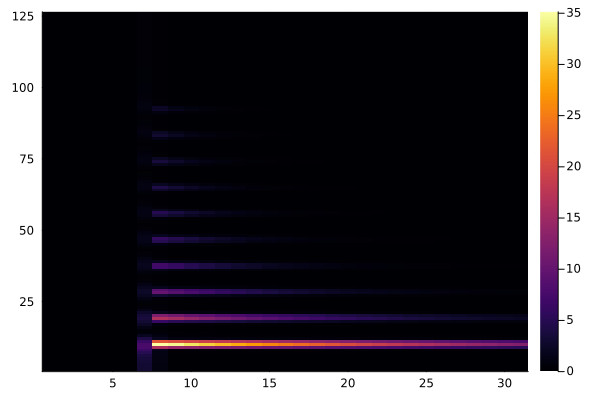

In [119]:
heatmap(S[1])

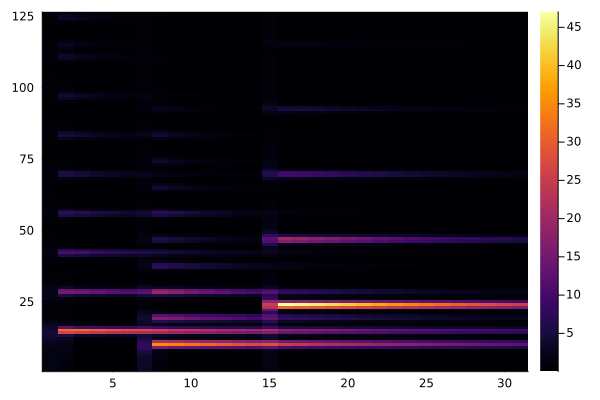

In [80]:
heatmap(sum(Si for Si ∈ S))

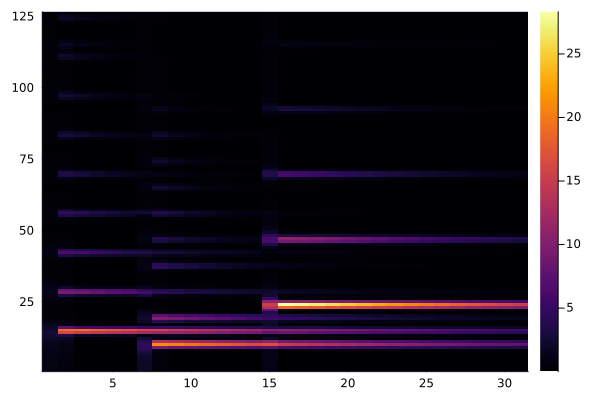

In [81]:
heatmap(V)

In [104]:
# ╔═╡ 01c584d6-b102-431d-bc05-f43d8f60d36c
# Define the ALS NN Layer
ReLU(x) = max.(x, 0)

struct MyLayer
    W
end

W_init = abs.(randn((m,r))) #use the same random initialization
function MyLayer(m,r)
    W = W_init
    MyLayer(W)
end

function (a::MyLayer)((H, V))
    W = a.W #force the matrix to be positive
    ϵ = 1e-6 #avoid divide by zero problems, equivilent to adding an L1 regularizer
    λ = 0#1e-1 # adds an L2 regularizer to the minimization 1/2|V-WH|+ϵ|H|₁+λ/2|H|₂^2
    #return (H .* (W'*V) ./ (W'*W*H .+ ϵ + λ.*H), V) #one update step
    return (H .* (W'*V) ./ (W'*W*H .+ ϵ + λ.*H), V)
end

Flux.@functor MyLayer (W,) #declare the weights W as trainable parameters

In [105]:
# Define the model
struct MyModel
	chain::Chain
end
H_init = abs.(randn((r,n))) 
function (m::MyModel)(V::Matrix{Float64})
	#H_init = W \ V # Least Squares Initialization
	(H, _) = m.chain((H_init, V))
	W = Flux.params(m)[1]
	S = [w*h' for (w,h) ∈ zip(eachcol(W),eachrow(H))] #reconstruct every source
	return S
end

function (m::MyModel)(V::Vector{Matrix{Float64}})
	return m.(V) #apply m to all elements in V
end
	
Flux.@functor MyModel

In [106]:
# ╔═╡ 6e567463-2b84-4472-9fa6-050e2e97d4ce
begin
	# Create the NN
	my_layer = MyLayer(m,r)
	chain = Chain([my_layer for _ ∈ 1:n_layers]) # shared parameters
	#chain = Chain([MyLayer(m,r) for _ ∈ 1:n_layers]) # different parameters
	model = MyModel(chain)
end

# ╔═╡ 32f07151-5b8c-4412-a3f3-b85515d93fa9
model(train_V[1])

# ╔═╡ fd523a2f-cde6-4b2f-977f-bc32ea9c6dfb
Flux.params(model)

Params([[0.7172317088693063 0.43482036621714387 0.845094996974536; 0.6879693031990625 0.7936077330651957 0.0574985510032871; … ; 0.8076597667631031 1.1465232822085463 1.8446152548599042; 0.5492211937908196 0.3948491753515696 0.07867670445497243]])

In [107]:
# ╔═╡ f719af93-5fd5-4690-b9d4-9ba5852b5f6d
function loss(model, V_input, S_truth)
    S_output = model(V_input)
    return sum(mse(S1, S2) for (S1,S2) ∈ zip(S_output, S_truth))
end

# ╔═╡ fa4f0aa7-07d4-4960-b4e8-86a8e1d9e51b
opt = Descent()

# ╔═╡ af0b1669-f09c-430a-823c-2501fa6104e1
#train!(loss, model, data, opt)

# ╔═╡ 572e17af-3a5a-42e1-a790-9c545e202ae4
function my_train(maxit=50)
    train_test_ratio = 1#train_set_size/test_set_size
    training_loss = zeros(1,maxit)
    testing_loss  = zeros(1,maxit)
    for i ∈ 1:maxit
        println("i = ",i)
        train!(loss, model, data, opt)
        training_loss[i] = mean(loss(model, V, H) for (V,H) ∈ data)
        testing_loss[i]  = mean(loss(model, V, H) for (V,H) ∈ testing_data)
    end
    return training_loss, testing_loss*train_test_ratio
end

my_train (generic function with 2 methods)

In [108]:
train!(loss, model, data, opt)

In [115]:
maxit = 5#50
training_loss, testing_loss = my_train(maxit)

i = 1


i = 2


i = 3


i = 4


i = 5


([22.22592801096354 22.046317324484644 … 21.634624133925914 21.404248143017732], [21.51049975562274 21.337131046305124 … 20.923750545067044 20.69183588361122])

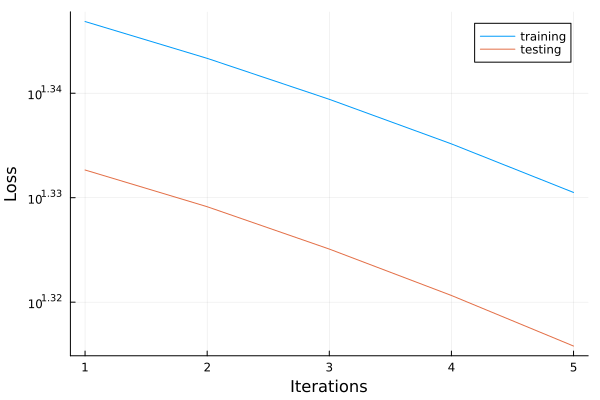

In [116]:
# ╔═╡ 08987c7d-2029-4be0-8e49-9e92b4912477
plot(1:maxit,[training_loss',testing_loss'],label=["training" "testing"], xlabel="Iterations", ylabel="Loss", yscale=:log10)

In [117]:
# ╔═╡ 7ab02d01-7201-42eb-825f-0e9516cddecd
learned_W = abs.(Flux.params(model)[1])

# ╔═╡ cdd94d93-deaa-4ff5-a78f-ee76b61b2f72
function plot_Ws(W)
	p1 = plot(freqs,W[:,1], color=:blue, label = "w1")
	p2 = plot(freqs,W[:,2], color=:red, label = "w2")
	p3 = plot(freqs,W[:,3], color=:green, label = "w3", xlabel = "frequency (Hz)")
	plot(p1,p2,p3, layout=(r,1))
	plot!(xticks=0:100:1400)
end

# ╔═╡ 89305234-16cb-4704-9a11-dcf5db583ae8
function plot_Hs(H)
	p1 = plot(times,H[1,:], color=:blue, label = "h1")
	p2 = plot(times,H[2,:], color=:red, label = "h2")
	p3 = plot(times,H[3,:], color=:green, label = "h3", xlabel = "time (s)")
	plot(p1,p2,p3, layout=(r,1))
end

plot_Hs (generic function with 1 method)

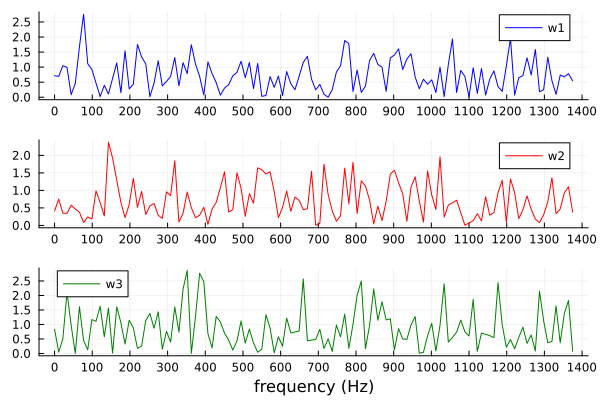

In [118]:
# ╔═╡ 182c37b5-80c9-4a82-95e2-957859fa93b9
plot_Ws(learned_W)

In [ ]:
# ╔═╡ c1e6d11f-0b80-464e-96ce-cba6e3ef37a0
#plot_Hs(model(train_V[1])[1])

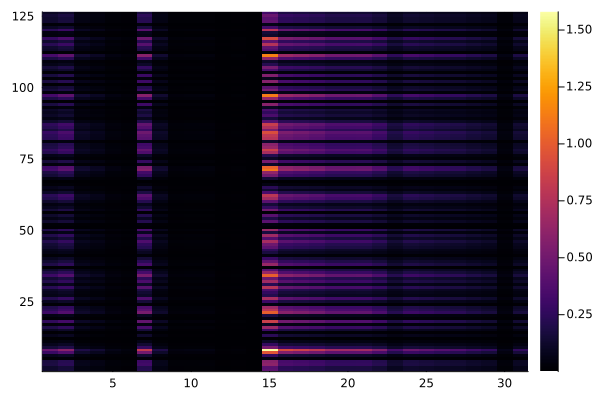

In [111]:
heatmap(model(train_V[1])[1])

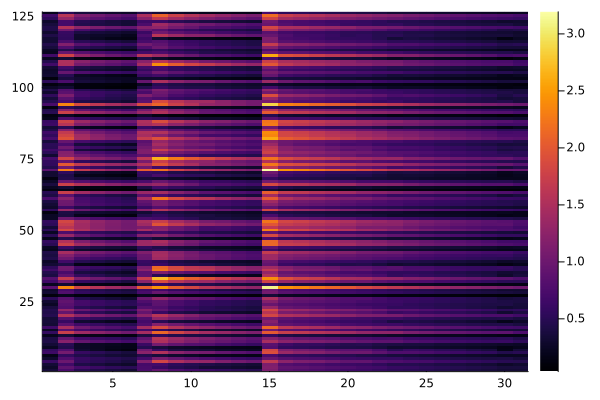

In [112]:
heatmap(sum(model(train_V[1])))

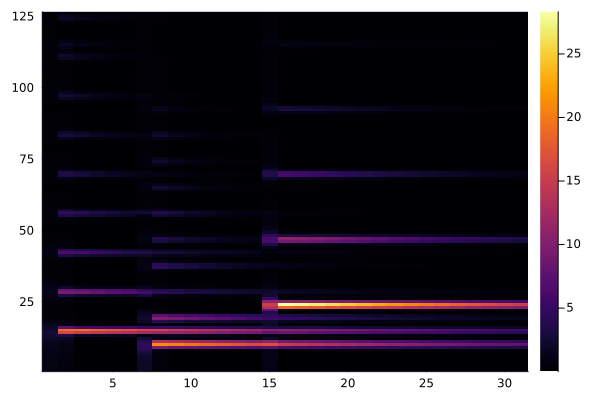

In [113]:
heatmap(train_V[1])

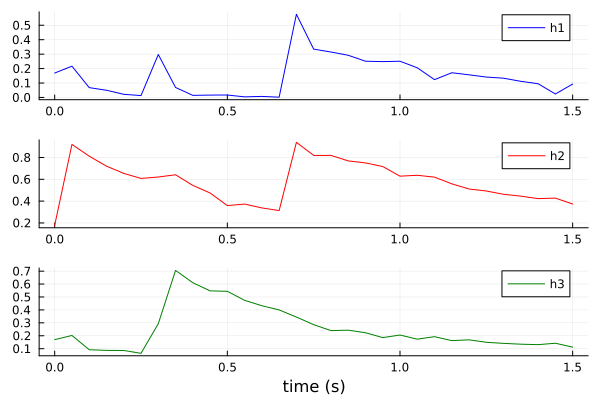

In [114]:
(H, _) = model.chain((H_init, train_V[1]))
plot_Hs(H)